In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from igraph import Graph, RainbowPalette, plot
import cairo

In [110]:
def self_join_df(df):
    # Ensure that the DataFrame has 'user_id' and 'business_id' columns
    if 'user_id' not in df.columns or 'business_id' not in df.columns:
        raise ValueError("DataFrame must contain 'user_id' and 'business_id' columns.")
    
    # Perform a self-join on 'user_id'
    joined_df = df.merge(df, on='user_id', suffixes=('_left', '_right'))
    
    # Filter rows where 'business_id' is different
    result_df = joined_df[joined_df['business_id_left'] != joined_df['business_id_right']]
    
    # Drop unnecessary columns
    result_df = result_df[['user_id', 'business_id_left', 'business_id_right', 'stars_left', 'stars_right']]

    # Reset the index
    result_df.reset_index(drop=True, inplace=True)
    
    return result_df

In [111]:
# Load the restaurant dataset
restaurants = pd.read_csv('data/tucson_restaurants.csv')

# Count the number of categories in each row
restaurants['numcat'] = restaurants['categories'].str.split(',').apply(len)

# filter out rows with 3 categories
df_res = restaurants[restaurants['numcat'] == 3].copy(deep=True)
df_res.reset_index(drop=True, inplace=True)
print('shape .::.', df_res.shape)

# Create a new column for each category
df_res['category1'] = df_res['categories'].str.split(',').apply(lambda x: x[0])
df_res['category2'] = df_res['categories'].str.split(',').apply(lambda x: x[1])
df_res['category3'] = df_res['categories'].str.split(',').apply(lambda x: x[2])

# Drop unnecessary columns
df_res = df_res[['business_id', 'name', 'stars', 'review_count', 'is_open', 'category1', 'category2', 'category3']]
df_res.head()

shape .::. (452, 7)


business_id                           name  stars  review_count  \
0  iNMdSi5bmvGSGeRQiUW4dw                        Wendy's    2.5            14   
1  UAi8nZY-tCA758y4_8Meuw         Fullylove’s Restaurant    4.5            25   
2  5N5K-B0pA3as6dvl_ha5BQ  Famous Sam's Restaurant & Bar    2.0            25   
3  lhsQkb5nhf-Kd5OvgB9MNg                  Sachiko Sushi    3.5           191   
4  XyGRDrgCK0z4CiA6nhwEaw       Persian Room Fine Dining    4.5           258   

   is_open    category1         category2                category3  
0        1    Fast Food           Burgers              Restaurants  
1        0        Vegan    American (New)              Restaurants  
2        0      Burgers       Restaurants   American (Traditional)  
3        1     Japanese       Restaurants               Sushi Bars  
4        1  Restaurants   Persian/Iranian            Mediterranean

In [115]:
# Load the review dataset
reviews = pd.read_csv('data/tucson_reviews.csv')

# Filter out rows that are not in the restaurant dataset
reviews_df = reviews[reviews['business_id'].isin(df_res['business_id'])].copy(deep=True)

# Reset the index
reviews_df.reset_index(drop=True, inplace=True)

print('Old shape .::.', reviews.shape)
print('New shape .::.', reviews_df.shape)

# Perform self join
joined_df = self_join_df(reviews_df)
# Save the DataFrame to a CSV file
# joined_df.to_csv('output/tucson_reviews_self_joined.csv', index=False)
print('Joined shape .::.', joined_df.shape)
joined_df.head()


Old shape .::. (191113, 9)
New shape .::. (22029, 9)
Joined shape .::. (54076, 5)


user_id        business_id_left       business_id_right  \
0  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  vzvm7_QXEDaMTxMOKLBNyQ   
1  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  36rz3AMPh8ETMJq7cTG2Rw   
2  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  6BZ1gasOkF1mNfmUxfYqhA   
3  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  dMGWB4TEfEhgInQefGimAw   
4  1yXp7EkfmcxXOomfHxTu-g  B10mqANgHvL8gBteo1UhAA  EwWcloIMj8zflH5Dc16-nw   

   stars_left  stars_right  
0           2            3  
1           2            2  
2           2            3  
3           2            5  
4           2            5

In [116]:
# Create an sample of the DataFrame with 5,000 rows and stars_left == stars_right
df_join_sample = joined_df[joined_df.stars_left == joined_df.stars_right].sample(5_000, random_state=42)

# Create a links dataframe 
links = df_join_sample[['business_id_left', 'business_id_right']].copy(deep=True)
links['weight'] = 5
links.columns = ['source', 'target', 'weight']
links.reset_index(drop=True, inplace=True)
# links.to_csv('output/links.csv', index=False)
links.head()

source                  target  weight
0  _uDhUdcNBtgiOXPGPWunoQ  Zg83olSjsdXAhE5EEy5IcQ       5
1  LIcsCCOYqBO9k2tiO4Mrow  YdZS3QkpjgHU2zIJ_bqy_A       5
2  wexGsdw5Wz85-hOBx9r2Tg  gwOiwfeHxBemcMV6u1dI_w       5
3  aDL_KdxbDRT5s51Jtn9V5g  q_fvK1U95dwKebz6JDRSxg       5
4  wLybne33jvVt6rs9ji8bww  t-abv5g6bjbYwLerN_4VKw       5

In [117]:
nodes = df_res.drop_duplicates().copy(deep=True)
nodes.reset_index(drop=True, inplace=True)
nodes.columns = ['business_id', 'business_name', 'stars', 'review_count', 'is_open', 'category1', 'category2', 'category3']
# nodes.to_csv('output/nodes.csv', index=False)
nodes.head()

business_id                  business_name  stars  review_count  \
0  iNMdSi5bmvGSGeRQiUW4dw                        Wendy's    2.5            14   
1  UAi8nZY-tCA758y4_8Meuw         Fullylove’s Restaurant    4.5            25   
2  5N5K-B0pA3as6dvl_ha5BQ  Famous Sam's Restaurant & Bar    2.0            25   
3  lhsQkb5nhf-Kd5OvgB9MNg                  Sachiko Sushi    3.5           191   
4  XyGRDrgCK0z4CiA6nhwEaw       Persian Room Fine Dining    4.5           258   

   is_open    category1         category2                category3  
0        1    Fast Food           Burgers              Restaurants  
1        0        Vegan    American (New)              Restaurants  
2        0      Burgers       Restaurants   American (Traditional)  
3        1     Japanese       Restaurants               Sushi Bars  
4        1  Restaurants   Persian/Iranian            Mediterranean

In [118]:
# Create a graph from the links and nodes
net = Graph.DataFrame(links, directed=True, use_vids=False, vertices=nodes)

In [119]:
print(net)

IGRAPH DNW- 452 5000 --
+ attr: business_name (v), category1 (v), category2 (v), category3 (v),
  is_open (v), name (v), review_count (v), stars (v), weight (e)
+ edges (vertex names):
_uDhUdcNBtgiOXPGPWunoQ->Zg83olSjsdXAhE5EEy5IcQ,
LIcsCCOYqBO9k2tiO4Mrow->YdZS3QkpjgHU2zIJ_bqy_A,
wexGsdw5Wz85-hOBx9r2Tg->gwOiwfeHxBemcMV6u1dI_w,
aDL_KdxbDRT5s51Jtn9V5g->q_fvK1U95dwKebz6JDRSxg,
wLybne33jvVt6rs9ji8bww->t-abv5g6bjbYwLerN_4VKw,
5YRHE2foNVmv1n8VIJcb-A->wzPc5d1l0PpxQLQDhh8T2w,
P35nwRGaG1FMn-l8xPEY2Q->KAk07Tbv0UsoY-s7RYfepg,
RHdEScVIAQ7xzFFMiQEnAQ->gtuoRlBPqoTIEPrcfbIP-g,
eIk4_wRFDQGH7UOYF6maJA->hzXAxu35F32Ob9uVCh-dIQ,
5CX7rtnwYnmqFCihOyWivg->KJibkIOx_vZxq1ZHhtLTCg,
SVJJIoAiW3vHwoSpVnUcLQ->wLybne33jvVt6rs9ji8bww,
Wp9D-r8Ap1Fv0IIM0zGfoQ->zL7wVx6Ihf1VEb9Wi7P0bw,
KZA_HEOsBXf8dtrk9rqNJA->ab8i075-Tjju3WvcsXTp0g,
ZCkc45yLiM93rWxroR54_Q->mTnp8g8vFnuJso_NK7sR4A,
gtuoRlBPqoTIEPrcfbIP-g->QCPUoVbzkTAu1gkCrZlPaQ,
ta8tixXzHXFogPiYlB2a5A->q_fvK1U95dwKebz6JDRSxg,
dMGWB4TEfEhgInQefGimAw->l8yqThofpWGUs6lxOeIdOA,

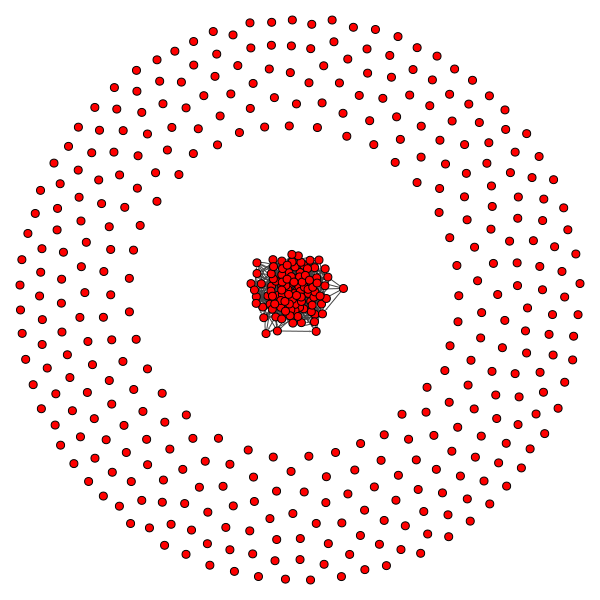

In [19]:
plot(net, edge_arrow_size=0.2, vertex_size=8)

IGRAPH DNW- 452 916 --
+ attr: business_name (v), category1 (v), category2 (v), category3 (v),
  is_open (v), name (v), review_count (v), stars (v), weight (e)
+ edges (vertex names):
lhsQkb5nhf-Kd5OvgB9MNg->cuYMRqzehT24XJk-YSrExw,
lhsQkb5nhf-Kd5OvgB9MNg->mwhnPkUD4fsitu8vk3Y6CA,
lhsQkb5nhf-Kd5OvgB9MNg->5XJsZt4HFjSbAdc4dkWVKQ,
lhsQkb5nhf-Kd5OvgB9MNg->5YRHE2foNVmv1n8VIJcb-A,
lhsQkb5nhf-Kd5OvgB9MNg->eGi7CE2YaN6YMiGyXNi8XQ,
lhsQkb5nhf-Kd5OvgB9MNg->nEaTbGFlU7d9eLU2kl6KBw,
lhsQkb5nhf-Kd5OvgB9MNg->g9DDXMuDwaW-GtD2f6xl6A,
XyGRDrgCK0z4CiA6nhwEaw->wexGsdw5Wz85-hOBx9r2Tg,
XyGRDrgCK0z4CiA6nhwEaw->RHdEScVIAQ7xzFFMiQEnAQ,
XyGRDrgCK0z4CiA6nhwEaw->7PbJjm9Oeq9LqM9zKsF-8g,
XyGRDrgCK0z4CiA6nhwEaw->ta8tixXzHXFogPiYlB2a5A,
5Ce3lZksYVkCbrihqylVHQ->KAk07Tbv0UsoY-s7RYfepg,
5Ce3lZksYVkCbrihqylVHQ->wzPc5d1l0PpxQLQDhh8T2w,
5Ce3lZksYVkCbrihqylVHQ->Wp9D-r8Ap1Fv0IIM0zGfoQ,
5Ce3lZksYVkCbrihqylVHQ->CJoO4HYD0tZRXlZqA04wmw,
5Ce3lZksYVkCbrihqylVHQ->LIcsCCOYqBO9k2tiO4Mrow,
5Ce3lZksYVkCbrihqylVHQ->l8yqThofpWGUs6lxOeIdOA,


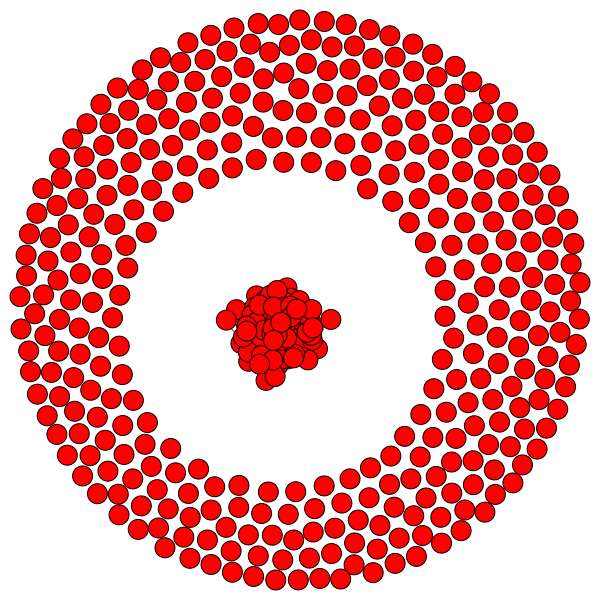

In [20]:
net_simp = net.simplify(multiple=True, loops=True, combine_edges=dict(weight="sum"))

print(net_simp)
plot(net_simp, edge_arrow_size=0.4)

In [21]:
# Density: The proportion of present edges from all possible edges in the network
edge_density = net.density(loops=False)
print(f"Density: {edge_density:0.4f}")
print(f"or... {net.ecount() / (net.vcount() * (net.vcount() - 1)):0.4f}")

Density: 0.0045
or... 0.0045


In [22]:
# Diameter: longest geodesic distance (eccentricity) between any two vertices in the network
diameter_undirected = net.diameter(directed=False, weights=None)
print(f"Undirected diameter: {diameter_undirected}")
diameter_directed = net.diameter(directed=True, weights=None)
print(f"Directed diameter: {diameter_directed}")
diameter_weighted = net.diameter(directed=False, weights="weight")
print(f"Weighted undirected diameter: {diameter_weighted}")

Undirected diameter: 3
Directed diameter: 4
Weighted undirected diameter: 15.0


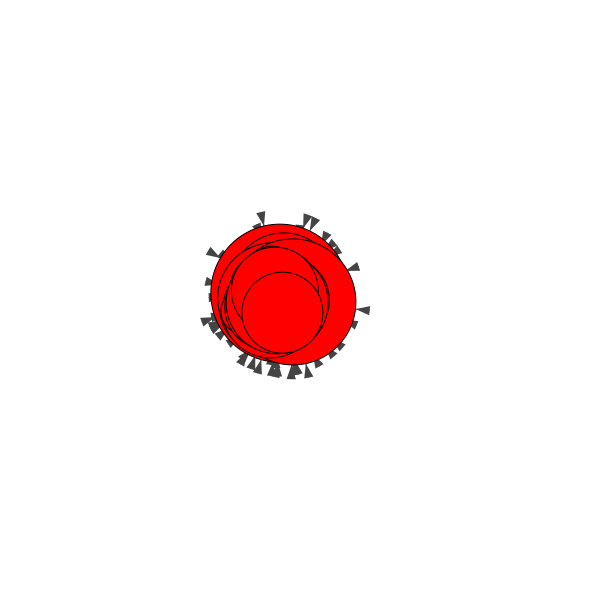

In [23]:
# Node degrees: how many edges are connected to a node
# The mode="ALL" parameter means that it calculates the total degree, considering both incoming and outgoing edges for directed graphs
deg = net.degree(mode="ALL")

# plot the network with node size proportional to degree
plot(net, vertex_size=[d * 3 for d in deg])

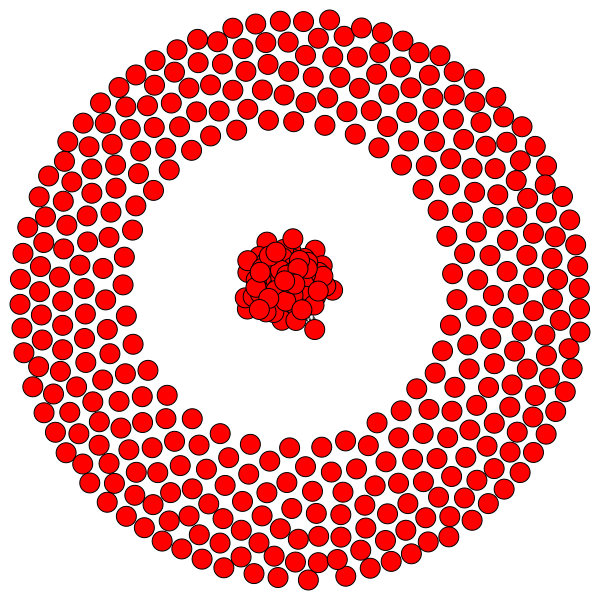

In [24]:
# Plot with curved edges
plot(net, edge_arrow_size=0.4, edge_curved=0.1)

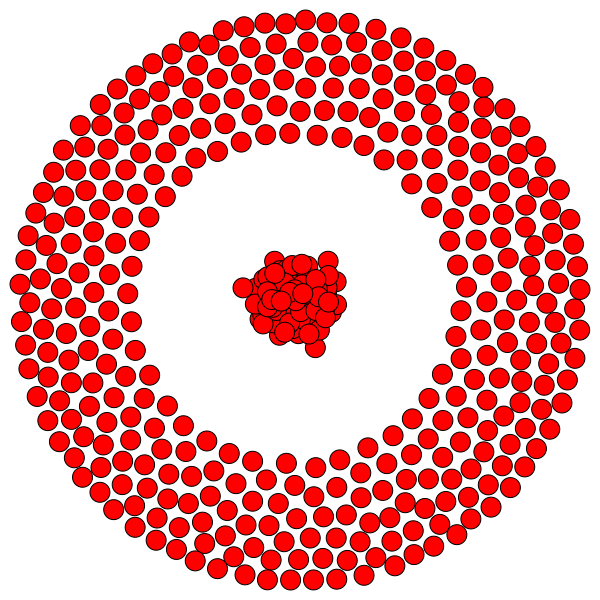

In [25]:

# Set edge color to gray, and the node color to orange
visual_style = {}
# Set edge width based on weight
visual_style["edge_width"] = [1 + weight / 12 for weight in net.es["weight"]]
# Change arrow size and edge color
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_color"] = "gray80"

plot(net, **visual_style)

In [26]:
# Community detection based on edge betweenness (Newman-Girvan)
# High-betweenness edges are removed sequentially (recalculating at each step) and the best partitioning of the network is selected.
communities = net.community_edge_betweenness() 
communities = communities.as_clustering() # just for ease of use

# coloring the nodes based on the community they belong to
num_communities = len(communities)
palette = RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    net.vs[community]["color"] = i
    community_edges = net.es.select(_within=community)
    community_edges["color"] = i

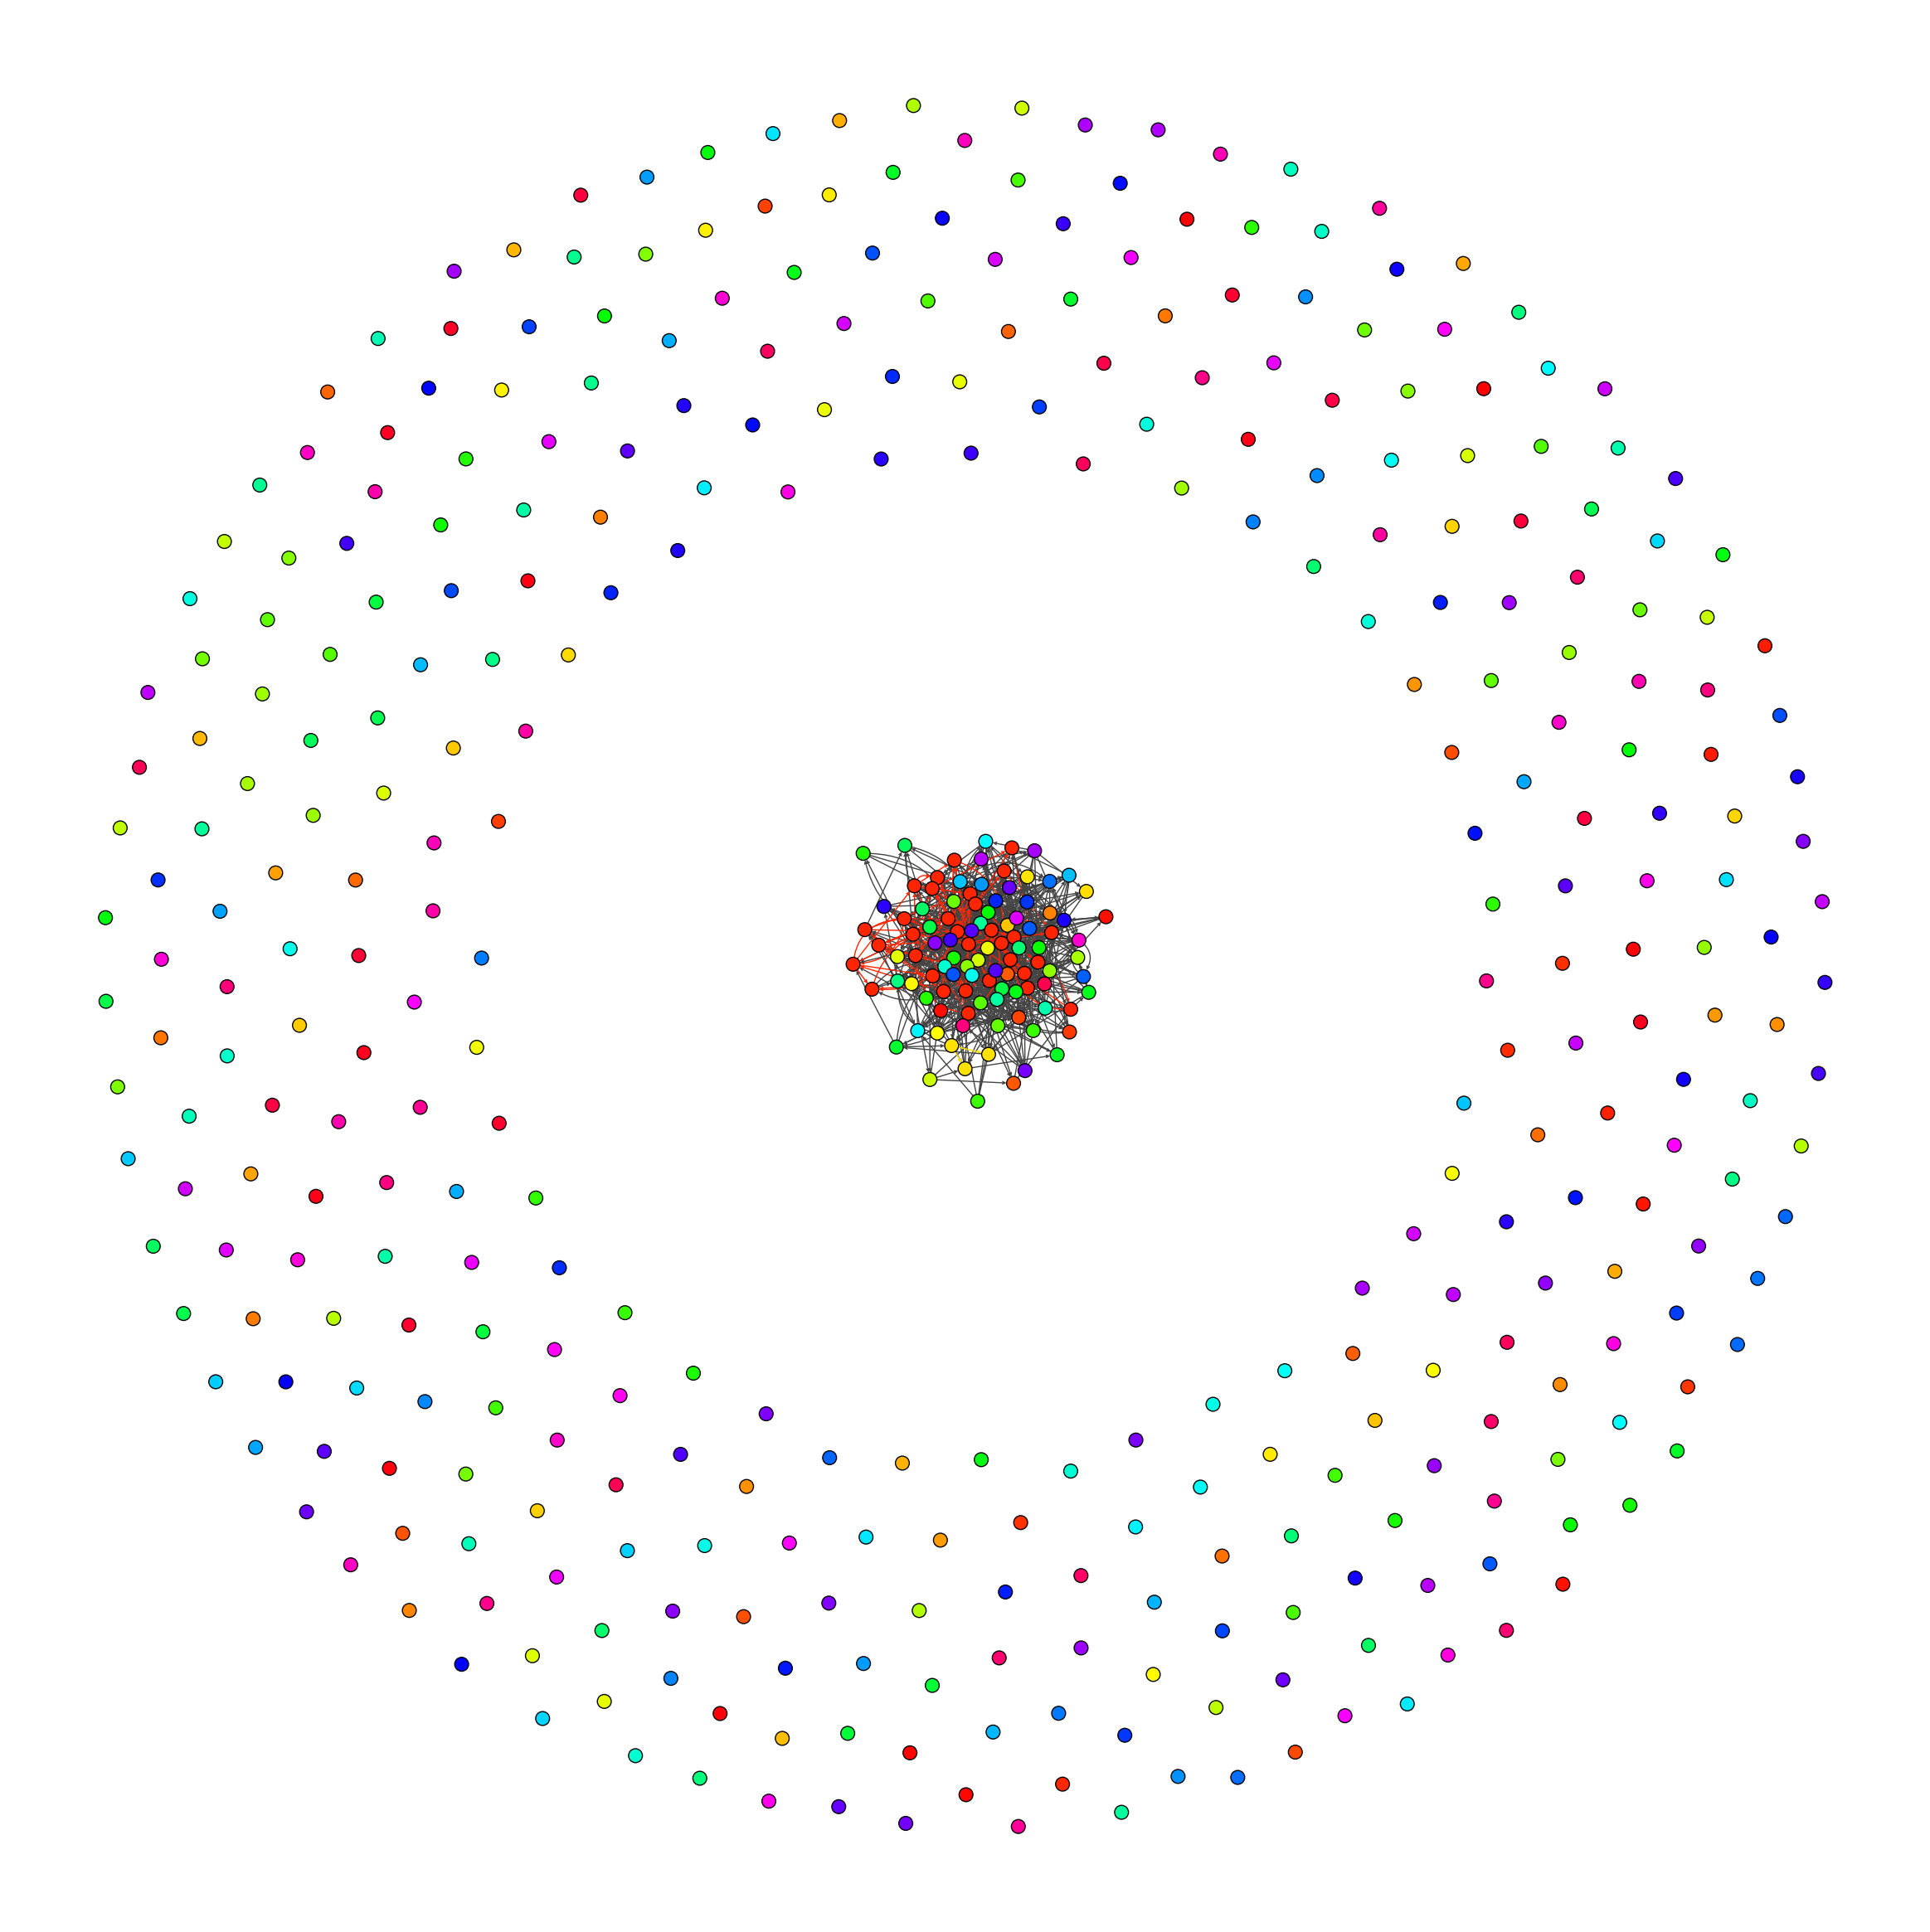

In [27]:
fig, ax = plt.subplots(figsize=(30, 30))
plot(
    communities,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=0.3,
)

# Create a custom color legend
""" legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
) """
plt.show()

In [90]:
degree_centrality = net_simp.degree()
betweenness_centrality = net_simp.betweenness()
cluster_coeff = net_simp.transitivity_local_undirected(mode="zero")
# calculate the eigenvector centrality
eigenvector_centrality = net_simp.eigenvector_centrality(directed=False, weights="weight")
# calculate the pagerank
pagerank = net_simp.pagerank(directed=False, weights="weight")
# calculate closeness centrality
closeness_centrality = net_simp.closeness(normalized=True)

In [91]:
# Combine the centrality measures and cluster coefficients into a dictionary
node_metrics = {
    "Degree Centrality": degree_centrality,
    "Betweenness Centrality": betweenness_centrality,
    "Cluster Coefficient": cluster_coeff,
    "Eigenvector Centrality": eigenvector_centrality,
    "PageRank": pagerank,
    "Closeness Centrality": closeness_centrality,
}

In [92]:
# Sort the nodes by the chosen metric (e.g., "Degree Centrality")
sorted_nodes = sorted(range(len(net_simp.vs)), key=lambda x: node_metrics["Degree Centrality"][x], reverse=True)

# Get the top 10 nodes based on the chosen metric
top_10_nodes = sorted_nodes[:10]

print(top_10_nodes)

[17, 77, 63, 50, 100, 22, 35, 80, 26, 82]


In [104]:
# Print the top 10 nodes and their metric values
top_10_data = []
for node in top_10_nodes:
    node_data = {"Node": node}
    for metric_name, metric_values in node_metrics.items():
        node_data[metric_name] = metric_values[node]
    top_10_data.append(node_data)

# Create a DataFrame from the list of dictionaries
top_10_df = pd.DataFrame(top_10_data)

# Print the DataFrame
top_10_df

Node  Degree Centrality  Betweenness Centrality  Cluster Coefficient  \
0    17                 46              685.213801             0.230769   
1    77                 42              765.314456             0.174603   
2    63                 37              427.096962             0.240860   
3    50                 35              412.738257             0.174194   
4   100                 34              389.272493             0.193548   
5    22                 32              399.242934             0.209360   
6    35                 32              351.293451             0.243386   
7    80                 32              334.255619             0.213793   
8    26                 31              338.122787             0.227920   
9    82                 29              318.965583             0.203704   

   Eigenvector Centrality  PageRank  Closeness Centrality  
0                1.000000  0.026087              0.620482  
1                0.526677  0.020920              0.602339  
2                0.657069  0.018629              0.581921  
3                0.548260  0.018588              0.585227  
4                0.558660  0.017588              0.581921  
5                0.520279  0.015862              0.578652  
6                0.608810  0.017049              0.578652  
7                0.559222  0.016523              0.578652  
8                0.647119  0.017620              0.562842  
9                0.433750  0.014293              0.578652

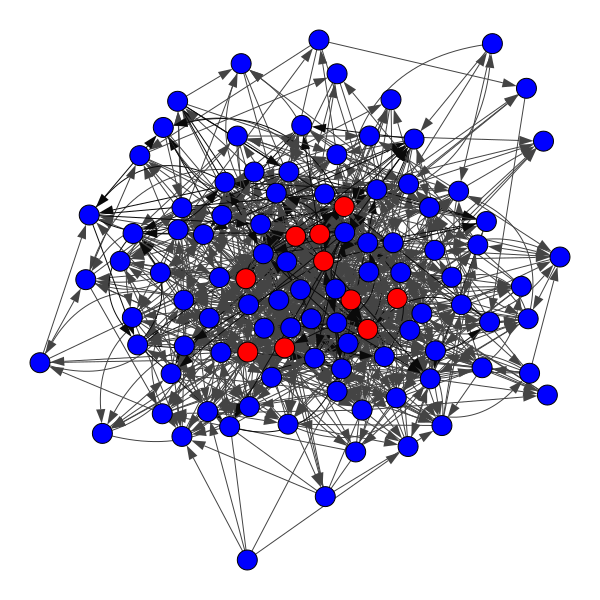

In [97]:
from igraph import Graph, plot
# Create a layout for the graph
layout = net_simp.layout("fr")

# Create a plot and highlight the top 10 nodes using the vertex_color parameter
plot(net_simp, layout=layout, bbox=(600, 600), margin=40, vertex_color=["red" if v.index in top_10_nodes else "blue" for v in net_simp.vs])

In [28]:
print(f"Number of communities: {num_communities}")

Number of communities: 419


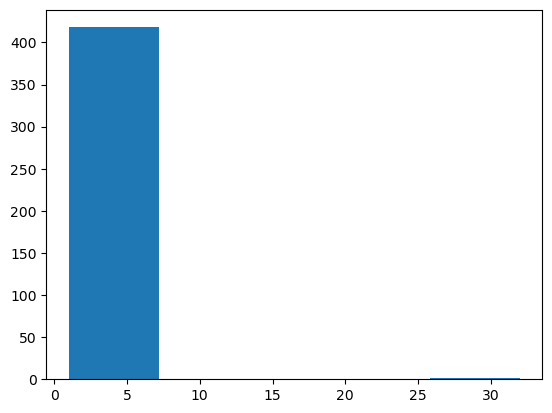

In [32]:
# plot histogram of community sizes
community_sizes = [len(community) for community in communities]
plt.hist(community_sizes, bins=5);

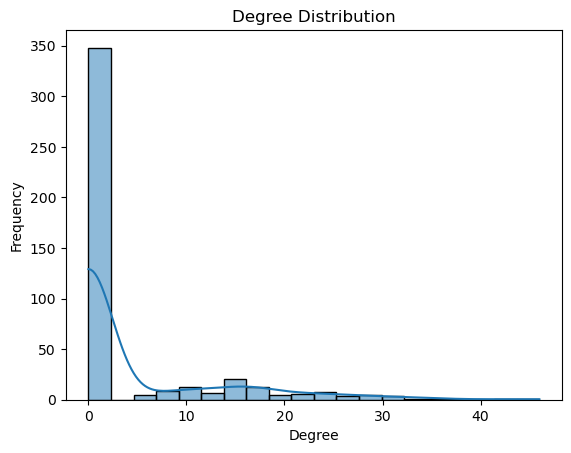

In [47]:
sns.histplot(deg, bins=20, kde=True)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

Vertices in the largest connected component: [3, 4, 10, 16, 19, 24, 25, 36, 54, 60, 62, 63, 64, 65, 70, 71, 73, 77, 81, 85, 87, 89, 96, 98, 99, 106, 107, 116, 118, 121, 122, 131, 136, 138, 140, 144, 147, 153, 154, 156, 157, 161, 164, 167, 168, 173, 175, 178, 179, 182, 186, 192, 195, 199, 207, 216, 221, 223, 232, 238, 239, 242, 248, 252, 262, 263, 268, 269, 271, 280, 284, 286, 290, 293, 305, 307, 309, 311, 317, 319, 323, 324, 329, 333, 338, 346, 350, 356, 362, 364, 375, 376, 387, 394, 411, 419, 423, 425, 427, 440, 445, 447, 448]


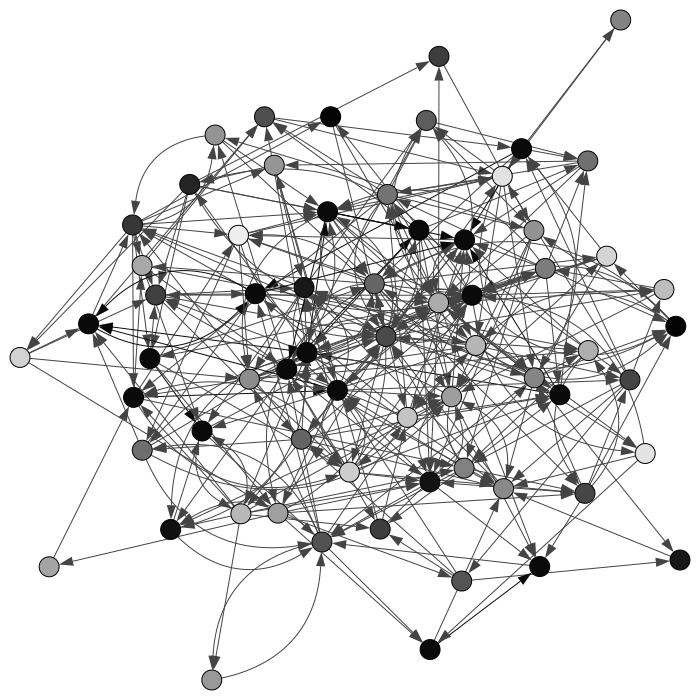

In [68]:
# Find connected components
components = net.components()

# Get the largest connected component
largest_component = max(components, key=len)

# Perform any analysis on the largest connected component
print("Vertices in the largest connected component:", largest_component)

# Plot the largest connected component
plot(net.subgraph(largest_component[0:65]), bbox=(700, 700))

In [62]:
len(largest_component)

103